In [1]:
import os
#from brapi_wrapper import BrAPIWrapper
import os
from utils import *
import yfinance as yf
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm


## Get Options chain for last day


In [2]:

from oplab_api import *
OPT=fetch_options_data()

In [3]:
OPT

,symbol,block_date,category,contract_size,days_to_maturity,due_date,exchange_id,isin,market_maker,maturity_type,...,security_category,spot_price,trades,bid_volume,ask_volume,time,type,last_trade_at,strike_eod,quotation_form
0,IBOVK10,2024-11-12,CALL,100,15,2024-11-13,BOVESPA,BRIBOV9K0DF2,False,EUROPEAN,...,8,129951.37,0,0,0,2024-10-23 13:00:00,CALL,-62167294412000,10000,NaN
1,IBOVW10,2024-11-12,PUT,100,15,2024-11-13,BOVESPA,BRIBOV9W0DF8,False,EUROPEAN,...,8,129951.37,0,0,0,2024-10-23 13:00:00,PUT,-62167294412000,10000,NaN
2,IBOVK700,2024-11-12,CALL,100,15,2024-11-13,BOVESPA,BRIBOV9K0G25,False,EUROPEAN,...,8,129951.37,0,0,0,2024-10-23 13:00:00,CALL,-62167294412000,70000,NaN
3,IBOVW700,2024-11-12,PUT,100,15,2024-11-13,BOVESPA,BRIBOV9W0G20,False,EUROPEAN,...,8,129951.37,0,0,0,2024-10-23 13:00:00,PUT,-62167294412000,70000,NaN
4,IBOVK780,2024-11-12,CALL,100,15,2024-11-13,BOVESPA,BRIBOV9K0FL5,False,EUROPEAN,...,8,129951.37,0,0,0,2024-10-23 13:00:00,CALL,-62167294412000,78000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,IBOVX140,2026-12-15,PUT,100,540,2026-12-16,BOVESPA,BRIBOV9X10V4,False,EUROPEAN,...,8,129951.37,0,0,0,2024-10-23 13:00:00,PUT,-62167294412000,140000,NaN
1106,IBOVL150,2026-12-15,CALL,100,540,2026-12-16,BOVESPA,BRIBOV9L11L8,False,EUROPEAN,...,8,129951.37,0,0,0,2024-10-23 13:00:00,CALL,-62167294412000,150000,NaN
1107,IBOVX150,2026-12-15,PUT,100,540,2026-12-16,BOVESPA,BRIBOV9X1129,False,EUROPEAN,...,8,129951.37,0,0,0,2024-10-23 13:00:00,PUT,-62167294412000,150000,NaN
1108,IBOVL7,2026-12-15,CALL,100,540,2026-12-16,BOVESPA,BRIBOV9L11M6,False,EUROPEAN,...,8,129951.37,0,0,0,2024-10-23 13:00:00,CALL,-62167294412000,170000,NaN


In [26]:
def calculate_variance(options):
    """
    Calculate the variance for a given set of options for a specific maturity.

    Parameters:
    - options: DataFrame containing options data for a specific maturity date.

    Returns:
    - sigma_squared: The variance for the given options.
    - F: The forward index level.
    - K0: The strike price closest to the forward index level.
    """
    import numpy as np

    # Ensure necessary columns are present
    required_columns = ['type', 'moneyness', 'strike', 'premium', 'spot_price', 'due_date', 'time', 'rate']
    for col in required_columns:
        if col not in options.columns:
            raise ValueError(f"Missing required column: {col}")

    # Extract parameters
    spot_price = options['spot_price'].iloc[0]
    R = options['rate'].iloc[0]
    T = (options['due_date'].iloc[0] - options['time'].iloc[0]).total_seconds() / (365.0 * 24 * 60 * 60)

    # Use 'premium' as the mid-price
    options = options.copy()
    options['mid_price'] = options['premium']

    # Select OTM and ATM options
    otm_calls = options[(options['type'] == 'CALL') & (options['moneyness'].isin(['OTM', 'ATM']))]
    otm_puts = options[(options['type'] == 'PUT') & (options['moneyness'].isin(['OTM', 'ATM']))]
    otm_options = pd.concat([otm_calls, otm_puts], ignore_index=True)

    # Ensure there are enough options
    if otm_options.empty:
        print(f"No OTM/ATM options available for maturity {options['due_date'].iloc[0]}")
        return None, None, None

    # Sort options by strike price
    otm_options = otm_options.sort_values('strike').reset_index(drop=True)

    # Calculate ΔK
    strikes = otm_options['strike'].values
    delta_K = np.zeros_like(strikes)

    # For options not at the edges
    delta_K[1:-1] = (strikes[2:] - strikes[:-2]) / 2

    # For the lowest strike price
    delta_K[0] = strikes[1] - strikes[0] if len(strikes) > 1 else strikes[0] * 0.01  # Approximate if only one strike

    # For the highest strike price
    delta_K[-1] = strikes[-1] - strikes[-2] if len(strikes) > 1 else strikes[-1] * 0.01  # Approximate if only one strike

    otm_options['delta_K'] = delta_K

    # Calculate contribution to variance
    otm_options['contribution'] = (otm_options['delta_K'] / (otm_options['strike'] ** 2)) * \
                                  np.exp(R * T) * otm_options['mid_price']

    # Sum contributions
    sigma_squared = (2 / T) * otm_options['contribution'].sum()

    # Calculate the forward index level (F)
    # Identify K0 (the strike price closest to the spot price)
    K0_row = otm_options.iloc[(otm_options['strike'] - spot_price).abs().argsort()[:1]]
    K0 = K0_row['strike'].values[0]

    # Find the call and put prices at K0
    call_at_K0 = options[(options['type'] == 'CALL') & (options['strike'] == K0)]
    put_at_K0 = options[(options['type'] == 'PUT') & (options['strike'] == K0)]

    if not call_at_K0.empty and not put_at_K0.empty:
        call_price = call_at_K0['mid_price'].values[0]
        put_price = put_at_K0['mid_price'].values[0]
        F = K0 + np.exp(R * T) * (call_price - put_price)
    else:
        # If missing data, approximate F
        F = spot_price * np.exp(R * T)

    return sigma_squared, F, K0


# VIX DAILY


In [4]:
def calculate_daily_vix(options_data):
    """
    Calculate the daily VIX values given options data.

    Parameters:
    - options_data: DataFrame containing options data for multiple dates.

    Returns:
    - vix_df: DataFrame containing dates and corresponding VIX values.
    """
    import pandas as pd
    from datetime import timedelta

    # Ensure the data has necessary columns
    required_columns = [
        'symbol', 'time', 'spot_price', 'type', 'due_date', 'strike', 'premium',
        'maturity_type', 'moneyness', 'rate'
    ]
    for col in required_columns:
        if col not in options_data.columns:
            raise ValueError(f"Missing required column: {col}")

    # Convert 'time' and 'due_date' to datetime
    options_data['time'] = pd.to_datetime(options_data['time'])
    options_data['due_date'] = pd.to_datetime(options_data['due_date']).dt.tz_localize(None)

    # Add 'date' column
    options_data['date'] = options_data['time'].dt.normalize()

    # Get unique dates
    unique_dates = options_data['date'].unique()
    vix_results = []

    # Iterate over each date to calculate VIX
    for current_date in sorted(unique_dates):
        daily_data = options_data[options_data['date'] == current_date]

        # Extract the spot price for the current date
        spot_price = daily_data['spot_price'].iloc[-1]

        # Calculate 'days_to_maturity'
        daily_data['days_to_maturity'] = (daily_data['due_date'] - daily_data['time']).dt.days

        # Filter options within a specific maturity range
        options_in_range = daily_data[(daily_data['days_to_maturity'] >= 23) & (daily_data['days_to_maturity'] <= 37)]
        if options_in_range.empty:
            options_in_range = daily_data[(daily_data['days_to_maturity'] >= 7) & (daily_data['days_to_maturity'] <= 180)]
            if options_in_range.empty:
                print(f"{current_date.date()}: Not enough options with suitable maturities.")
                vix_results.append({'date': current_date.date(), 'VIX': None})
                continue

        # Identify maturities bracketing 30 days
        options_in_range = options_in_range.sort_values('due_date')
        unique_maturities = options_in_range['due_date'].unique()
        target_date = current_date + timedelta(days=30)
        maturities_before = unique_maturities[unique_maturities <= target_date]
        maturities_after = unique_maturities[unique_maturities > target_date]

        if len(maturities_before) >= 1 and len(maturities_after) >= 1:
            T1_date = maturities_before[-1]
            T2_date = maturities_after[0]
            options_T1 = options_in_range[options_in_range['due_date'] == T1_date]
            options_T2 = options_in_range[options_in_range['due_date'] == T2_date]

            sigma1_sq, F1, K01 = calculate_variance(options_T1)
            sigma2_sq, F2, K02 = calculate_variance(options_T2)

            if sigma1_sq is None or sigma2_sq is None:
                print(f"{current_date.date()}: Failed to calculate variances.")
                vix_results.append({'date': current_date.date(), 'VIX': None})
                continue

            # Calculate times to expiration
            T1 = (T1_date - current_date).days / 365.0
            T2 = (T2_date - current_date).days / 365.0

            # Interpolate to 30 days
            T_30 = 30 / 365.0
            weight1 = (T2 - T_30) / (T2 - T1)
            weight2 = 1 - weight1
            sigma_30_sq = weight1 * sigma1_sq + weight2 * sigma2_sq
            VIX = 100 * np.sqrt(sigma_30_sq)
            vix_results.append({'date': current_date.date(), 'VIX': VIX})
        else:
            # Use the closest maturity
            closest_maturity_date = min(unique_maturities, key=lambda x: abs((x - target_date).days))
            options_T = options_in_range[options_in_range['due_date'] == closest_maturity_date]

            sigma_sq, F, K0 = calculate_variance(options_T)
            if sigma_sq is None:
                print(f"{current_date.date()}: Failed to calculate variance.")
                vix_results.append({'date': current_date.date(), 'VIX': None})
                continue

            # Calculate time to expiration
            T = (closest_maturity_date - current_date).days / 365.0

            # Adjust variance to 30 days
            T_30 = 30 / 365.0
            sigma_30_sq = sigma_sq * (T_30 / T)
            VIX = 100 * np.sqrt(sigma_30_sq)
            vix_results.append({'date': current_date.date(), 'VIX': VIX})

    # Create a DataFrame with the results
    vix_df = pd.DataFrame(vix_results)
    return vix_df


In [ ]:
df = calculate_daily_vix(hist)

## HISTORICAL VIX


In [5]:
hist = get_historical_options(spot='ibov', start='2022-01-01', end='2024-06-01')
hist

,symbol,time,spot_price,type,due_date,strike,premium,maturity_type,days_to_maturity,moneyness,delta,gamma,vega,theta,rho,volatility,poe,bs,date
0,IBOVA100,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,100000,6500,EUROPEAN,6,ATM,0.665250,0.000034,58.402813,-332.596873,14.913124,67.319,62.66,6499.9711,2022-01-03
1,IBOVA103,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,103000,2182,EUROPEAN,6,ATM,0.600429,0.000093,61.934977,-138.656526,14.337311,25.940,58.49,2182.0328,2022-01-03
2,IBOVA104,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,104000,1609,EUROPEAN,6,ATM,0.504977,0.000098,63.967812,-139.295521,12.111909,25.374,48.94,1609.0103,2022-01-03
3,IBOVA105,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,105000,1101,EUROPEAN,6,ATM,0.403624,0.000099,62.096937,-128.941412,9.725037,24.292,38.92,1100.9075,2022-01-03
4,IBOVA106,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,106000,900,EUROPEAN,6,ATM,0.327248,0.000084,57.877006,-131.655558,7.883030,26.753,31.25,900.0683,2022-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61855,IBOVV126,2024-05-31,122098.09,PUT,2024-10-16T00:00:00.000Z,126000,4605,EUROPEAN,98,ATM,-0.644807,0.000052,283.523712,-7.088144,-324.079149,9.472,66.66,4604.9114,2024-05-31
61856,IBOVV127,2024-05-31,122098.09,PUT,2024-10-16T00:00:00.000Z,127000,5095,EUROPEAN,98,ATM,-0.709757,0.000051,260.737593,-4.336379,-356.824848,8.734,72.81,5094.9607,2024-05-31
61857,IBOVX10,2024-05-31,122098.09,PUT,2024-12-18T00:00:00.000Z,100000,1085,EUROPEAN,143,OTM,-0.099093,0.000008,160.346170,-12.054379,-74.814599,23.367,13.33,1085.0525,2024-05-31
61858,IBOVX11,2024-05-31,122098.09,PUT,2024-12-18T00:00:00.000Z,110000,1895,EUROPEAN,143,OTM,-0.187079,0.000016,247.218818,-14.266330,-140.372219,18.776,22.74,1894.9478,2024-05-31


In [27]:
from oplab_api import *
from BrAPIWrapper import BrAPIWrapper

hist = get_historical_options(spot='ibov', start='2022-01-01', end='2024-06-01')

api = BrAPIWrapper()  # Will use BRAPI_API_KEY from environment variables
rates = api.get_prime_rate(start='01/01/2022', end='01/06/2024')
rates['date'] = pd.to_datetime(rates.index)
# rates.reset_index(drop=True, inplace=True)  # Drop the index to avoid conflict
# rates.rename(columns={'prime_rate': 'rate'}, inplace=True)

# hist['time'] = pd.to_datetime(hist['time'])
# hist['date'] = hist['time'].dt.normalize()
    hist = hist.merge(rates, on='date', how='left')
    hist['rate'] = hist['rate'] / 100

    # Check for missing risk-free rates
    if hist['rate'].isnull().any():
        missing_dates = hist[hist['rate'].isnull()]['date'].unique()
        raise ValueError(f"Missing risk-free rates for dates: {missing_dates}")


Formatting date: 01/01/2022
Formatting date: 01/06/2024


KeyError: 'date'

In [2]:
hist

,symbol,time,spot_price,type,due_date,strike,premium,maturity_type,days_to_maturity,moneyness,delta,gamma,vega,theta,rho,volatility,poe,bs,date,rate
0,IBOVA100,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,100000,6500,EUROPEAN,6,ATM,0.665250,0.000034,58.402813,-332.596873,14.913124,67.319,62.66,6499.9711,2022-01-03,0.000925
1,IBOVA103,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,103000,2182,EUROPEAN,6,ATM,0.600429,0.000093,61.934977,-138.656526,14.337311,25.940,58.49,2182.0328,2022-01-03,0.000925
2,IBOVA104,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,104000,1609,EUROPEAN,6,ATM,0.504977,0.000098,63.967812,-139.295521,12.111909,25.374,48.94,1609.0103,2022-01-03,0.000925
3,IBOVA105,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,105000,1101,EUROPEAN,6,ATM,0.403624,0.000099,62.096937,-128.941412,9.725037,24.292,38.92,1100.9075,2022-01-03,0.000925
4,IBOVA106,2022-01-03,103921.59,CALL,2022-01-12T00:00:00.000Z,106000,900,EUROPEAN,6,ATM,0.327248,0.000084,57.877006,-131.655558,7.883030,26.753,31.25,900.0683,2022-01-03,0.000925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61855,IBOVV126,2024-05-31,122098.09,PUT,2024-10-16T00:00:00.000Z,126000,4605,EUROPEAN,98,ATM,-0.644807,0.000052,283.523712,-7.088144,-324.079149,9.472,66.66,4604.9114,2024-05-31,0.001050
61856,IBOVV127,2024-05-31,122098.09,PUT,2024-10-16T00:00:00.000Z,127000,5095,EUROPEAN,98,ATM,-0.709757,0.000051,260.737593,-4.336379,-356.824848,8.734,72.81,5094.9607,2024-05-31,0.001050
61857,IBOVX10,2024-05-31,122098.09,PUT,2024-12-18T00:00:00.000Z,100000,1085,EUROPEAN,143,OTM,-0.099093,0.000008,160.346170,-12.054379,-74.814599,23.367,13.33,1085.0525,2024-05-31,0.001050
61858,IBOVX11,2024-05-31,122098.09,PUT,2024-12-18T00:00:00.000Z,110000,1895,EUROPEAN,143,OTM,-0.187079,0.000016,247.218818,-14.266330,-140.372219,18.776,22.74,1894.9478,2024-05-31,0.001050


In [4]:
# Calculate daily VIX values
vix_df = calculate_vix_df(spot='ibov', start='2022-01-01', end='2024-06-01')


F: 104.1948495790438, K0: 104.0
deltaK: 5.0
Q_K at K=120.0: 1000
Contribution to sigma_squared at K=120.0: 0.34813523556506176
F: 105.26437350859649, K0: 105.0
deltaK: 3.0
Q_K at K=125.0: 8000
Contribution to sigma_squared at K=125.0: 1.555846842886105
Date 2022-01-03: The calculated VIX-equivalent index is 2111.02
F: 103.75554858697583, K0: 103.0
deltaK: 2.0
Q_K at K=115.0: 100
Contribution to sigma_squared at K=115.0: 0.015158215093382053
F: 104.82056324447535, K0: 104.0
deltaK: 4.0
Q_K at K=122.0: 8000
Contribution to sigma_squared at K=122.0: 2.1771042490235524
Date 2022-01-04: The calculated VIX-equivalent index is 2238.41
F: 101.21215138502717, K0: 101.0
deltaK: 8.0
Q_K at K=120.0: 1000
Contribution to sigma_squared at K=120.0: 0.556691418337449
F: 102.25105895392458, K0: 102.0
deltaK: 6.0
Q_K at K=128.0: 500
Contribution to sigma_squared at K=128.0: 0.18536319437154444
Date 2022-01-05: The calculated VIX-equivalent index is 2297.31
F: 101.73900712784241, K0: 101.0
deltaK: 2.0
Q_

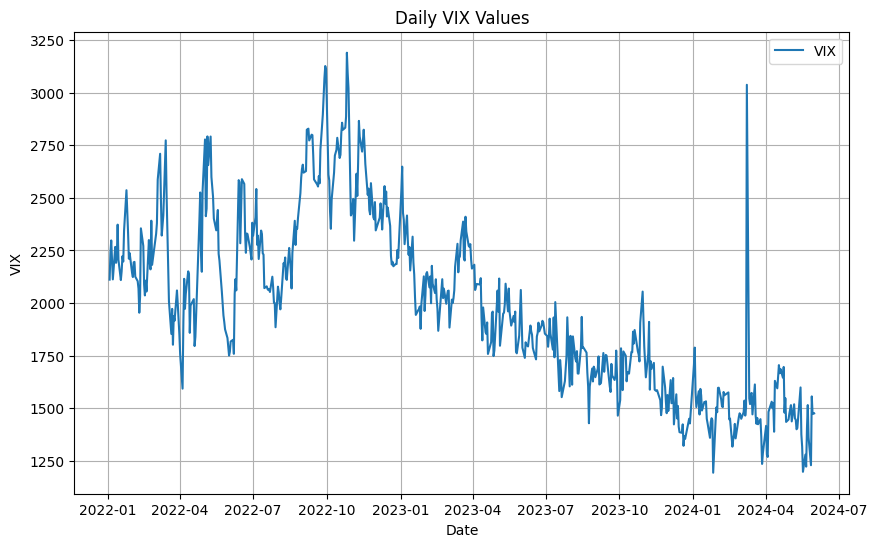

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(vix_df['Date'], vix_df['VIX'], label='VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('Daily VIX Values')
plt.legend()
plt.grid(True)
plt.show()

## Download IBOV Data for comparison

In [39]:
import yfinance as yf
# Define the ticker symbol for the IBOV index
ibov_ticker = '^BVSP'  # '^BVSP' is the ticker symbol for the Bovespa Index on Yahoo Finance

# Define the date range for the data
start_date = '2022-01-01'
end_date = '2024-09-01'

# Download historical data
ibov_data = yf.download(ibov_ticker, start=start_date, end=end_date)

# Display the first few rows
# Simplify the column structure
ibov_data.columns = [col[0] for col in ibov_data.columns]  # Take just the first part of each tuple

# Now calculate returns using the simplified column names
adj_close_values = ibov_data['Adj Close']
ibov_data['Log_Returns'] = np.log(adj_close_values / adj_close_values.shift(1))

# Drop the first row with NaN returns
ibov_data = ibov_data.dropna(subset=['Log_Returns'])

[*********************100%***********************]  1 of 1 completed


In [40]:
ibov_data

,Adj Close,Close,High,Low,Open,Volume,Log_Returns
Date,,,,,,,
2022-01-04 00:00:00+00:00,103514.0,103514.0,104276.0,103096.0,103922.0,11491600,-0.003934
2022-01-05 00:00:00+00:00,101006.0,101006.0,103514.0,100850.0,103514.0,0,-0.024527
2022-01-06 00:00:00+00:00,101561.0,101561.0,102235.0,101000.0,101006.0,11749200,0.005480
2022-01-07 00:00:00+00:00,102719.0,102719.0,102719.0,101104.0,101561.0,11733200,0.011338
2022-01-10 00:00:00+00:00,101945.0,101945.0,102719.0,101038.0,102719.0,10264700,-0.007564
...,...,...,...,...,...,...,...
2024-08-26 00:00:00+00:00,136889.0,136889.0,137013.0,135596.0,135608.0,7560000,0.009402
2024-08-27 00:00:00+00:00,136776.0,136776.0,137213.0,136664.0,136888.0,6745900,-0.000826
2024-08-28 00:00:00+00:00,137344.0,137344.0,137469.0,135746.0,136776.0,7457100,0.004144


## Plotting Results

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate daily logarithmic returns
adj_close_values = ibov_data['Adj Close']  # No need to index with ^BVSP since data is already filtered
ibov_data['Log_Returns'] = np.log(adj_close_values / adj_close_values.shift(1))

# Drop the first row with NaN returns
ibov_data = ibov_data.dropna(subset=['Log_Returns'], inplace=False)  # Explicitly set inplace=False


In [42]:
# Calculate daily logarithmic returns
adj_close_values = ibov_data['Adj Close']  # No need to index with ^BVSP since data is already filtered
ibov_data.loc[:, 'Log_Returns'] = np.log(adj_close_values / adj_close_values.shift(1))

# Drop the first row with NaN returns
ibov_data = ibov_data.dropna(subset=['Log_Returns'], inplace=False)  # Explicitly set inplace=False

# Shift returns to align future returns with the current date
ibov_data.loc[:, 'Future_Log_Returns'] = ibov_data['Log_Returns'].shift(-1)

# Calculate realized volatility over the next 14 days (based on optimal window analysis)
ibov_data.loc[:, 'Realized_Volatility'] = ibov_data['Future_Log_Returns'].rolling(window=30).std() * np.sqrt(252)

# Drop rows with NaN values (these occur at the end due to shifting)
ibov_data = ibov_data.dropna(subset=['Realized_Volatility'])  # Explicitly set inplace=False

In [43]:
ibov_data

,Adj Close,Close,High,Low,Open,Volume,Log_Returns,Future_Log_Returns,Realized_Volatility
Date,,,,,,,,,
2022-02-16 00:00:00+00:00,115181.0,115181.0,115734.0,114816.0,114830.0,12052100,0.004534,-0.014455,0.142409
2022-02-17 00:00:00+00:00,113528.0,113528.0,115214.0,113389.0,115181.0,10807500,-0.014455,-0.006717,0.143617
2022-02-18 00:00:00+00:00,112768.0,112768.0,114213.0,112701.0,113534.0,11300700,-0.006717,-0.009292,0.144816
2022-02-21 00:00:00+00:00,111725.0,111725.0,113405.0,111608.0,112880.0,7864900,-0.009292,0.010391,0.139736
2022-02-22 00:00:00+00:00,112892.0,112892.0,113315.0,111727.0,111727.0,12707000,0.010391,-0.007861,0.135116
...,...,...,...,...,...,...,...,...,...
2024-08-23 00:00:00+00:00,135608.0,135608.0,136478.0,135174.0,135174.0,8649400,0.003213,0.009402,0.124693
2024-08-26 00:00:00+00:00,136889.0,136889.0,137013.0,135596.0,135608.0,7560000,0.009402,-0.000826,0.124516
2024-08-27 00:00:00+00:00,136776.0,136776.0,137213.0,136664.0,136888.0,6745900,-0.000826,0.004144,0.124668


## Test Correlation and Plot  the accuracy of the model


In [46]:
# Convert 'Date' column in vix_df to datetime if it exists
if 'Date' in vix_df.columns:
    vix_df['Date'] = pd.to_datetime(vix_df['Date'])

# Reset the index of ibov_data to convert the Date index to a column
ibov_data.reset_index(inplace=True)

# Convert 'Date' column in ibov_data to datetime if it exists
if 'Date' in ibov_data.columns:
    ibov_data['Date'] = pd.to_datetime(ibov_data['Date'])

# Remove timezone information from both Date columns
vix_df['Date'] = vix_df['Date'].dt.tz_localize(None)  # Remove timezone from vix_df
ibov_data['Date'] = ibov_data['Date'].dt.tz_localize(None)  # Remove timezone from ibov_data

# Check if 'Date' column exists in ibov_data before merging
if 'Date' in ibov_data.columns:
    # Merge the VIX DataFrame with the realized volatility DataFrame
    merged_df = pd.merge(vix_df, ibov_data[['Date', 'Realized_Volatility']], left_on='Date', right_on='Date', how='left')

    # Drop redundant 'Date' column
    merged_df.drop(columns=['Date'], inplace=True)

    # Drop rows with NaN values in 'VIX' or 'Realized_Volatility'
    merged_df.dropna(subset=['VIX', 'Realized_Volatility'], inplace=True)

    # Multiply realized volatility by 100 to match VIX scale
    merged_df['Realized_Volatility'] *= 50

    # Calculate the correlation
    correlation = merged_df['VIX'].corr(merged_df['Realized_Volatility'])
    print(f"Correlation between VIX and realized volatility: {correlation:.4f}")
else:
    print("Warning: 'Date' column not found in ibov_data. Merge operation skipped.")

Correlation between VIX and realized volatility: 0.7531


## Plot Results

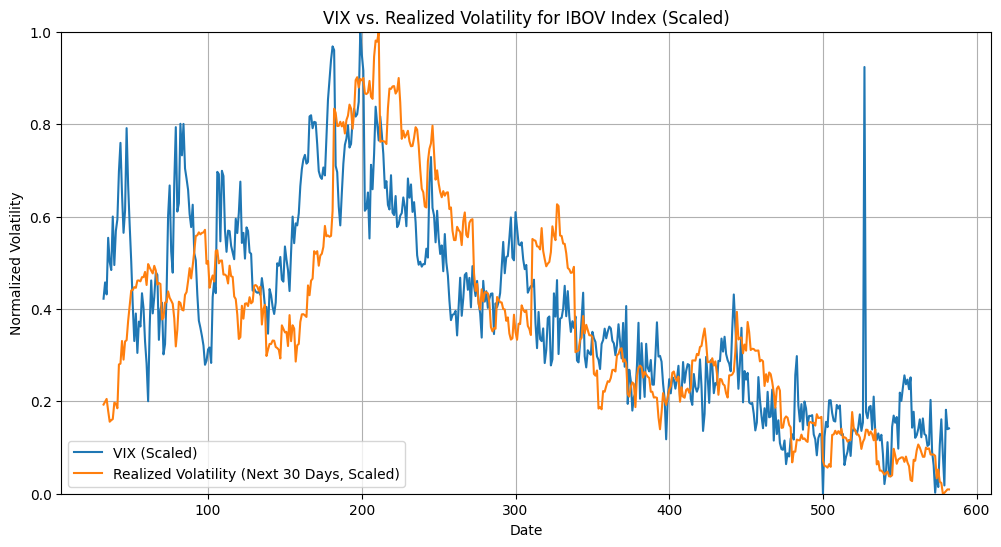

VIX range: 1193.75 to 3189.06
Realized Vol range: 5.22 to 15.05


In [48]:
# Plot the VIX and realized volatility over time
plt.figure(figsize=(12, 6))

# Use index if Date is the index, or merged_df['date'] if that's the column name
x_values = merged_df.index if 'Date' not in merged_df.columns else merged_df['date']

# Normalize the VIX and Realized Volatility to the same scale
vix_scaled = (merged_df['VIX'] - merged_df['VIX'].min()) / (merged_df['VIX'].max() - merged_df['VIX'].min())
realized_vol_scaled = (merged_df['Realized_Volatility'] - merged_df['Realized_Volatility'].min()) / (merged_df['Realized_Volatility'].max() - merged_df['Realized_Volatility'].min())

# Create plot with same y-axis scale
plt.plot(x_values, vix_scaled, label='VIX (Scaled)')
plt.plot(x_values, realized_vol_scaled, label='Realized Volatility (Next 30 Days, Scaled)')

# Set the same scale for both lines
plt.ylim(0, 1)  # Set y-axis limits to [0, 1] for normalized values

plt.xlabel('Date')
plt.ylabel('Normalized Volatility')
plt.title('VIX vs. Realized Volatility for IBOV Index (Scaled)')
plt.legend()
plt.grid(True)
plt.show()

# Print the range of values for verification
print(f"VIX range: {merged_df['VIX'].min():.2f} to {merged_df['VIX'].max():.2f}")
print(f"Realized Vol range: {merged_df['Realized_Volatility'].min():.2f} to {merged_df['Realized_Volatility'].max():.2f}")

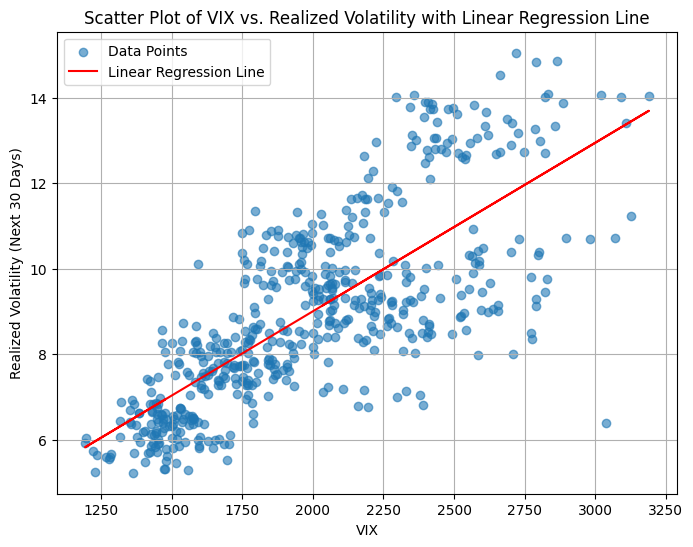

In [49]:
import matplotlib.pyplot as plt  # Changed from 'import matplotlib as plt'

# Scatter plot of VIX vs. Realized Volatility with linear regression line
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['VIX'], merged_df['Realized_Volatility'], alpha=0.6, label='Data Points')

# Calculate linear regression line
m, b = np.polyfit(merged_df['VIX'], merged_df['Realized_Volatility'], 1)
plt.plot(merged_df['VIX'], m*merged_df['VIX'] + b, color='red', label='Linear Regression Line')
plt.xlabel('VIX')
plt.ylabel('Realized Volatility (Next 30 Days)')
plt.title('Scatter Plot of VIX vs. Realized Volatility with Linear Regression Line')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/pb/m5zk890j6b7g6pz541ycs93h0000gn/T/ipykernel_19024/154747639.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=merged_df['VIX'], y=merged_df['Realized_Volatility'], cmap="Reds", shade=True, thresh=0)


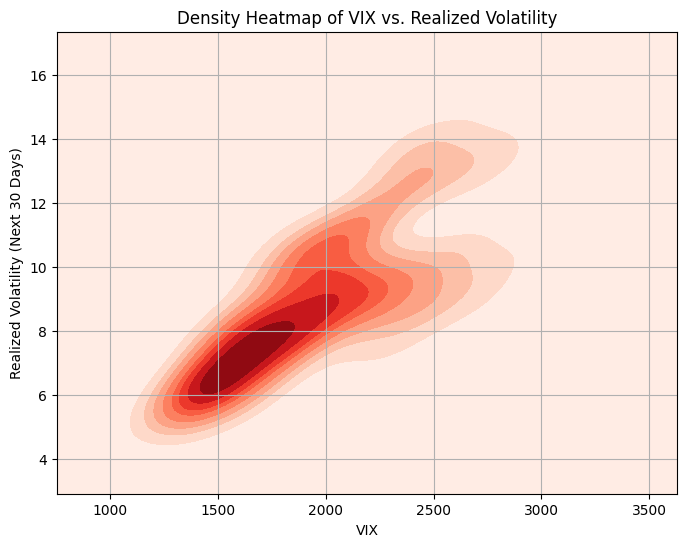

In [53]:
import seaborn as sns

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.kdeplot(x=merged_df['VIX'], y=merged_df['Realized_Volatility'], cmap="Reds", shade=True, thresh=0)
plt.xlabel('VIX')
plt.ylabel('Realized Volatility (Next 30 Days)')
plt.title('Density Heatmap of VIX vs. Realized Volatility')
plt.grid(True)
plt.show()


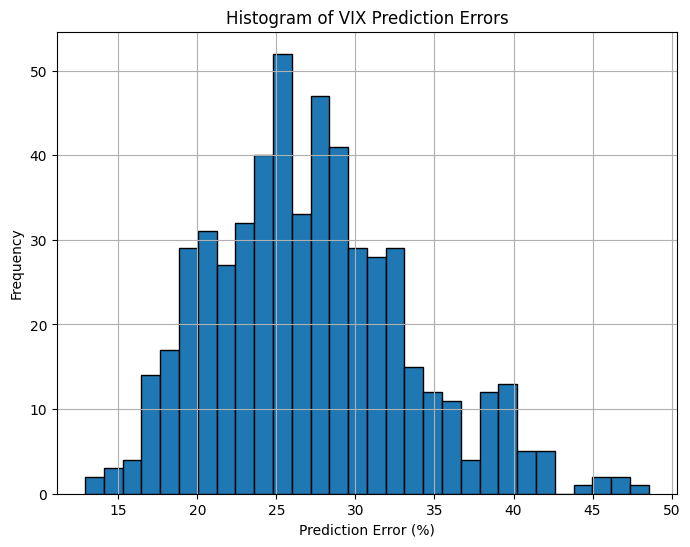

In [119]:
# Plot histogram of errors
plt.figure(figsize=(8, 6))
plt.hist(merged_df['VIX'] - merged_df['Realized_Volatility'], bins=30, edgecolor='black')
plt.xlabel('Prediction Error (%)')
plt.ylabel('Frequency')
plt.title('Histogram of VIX Prediction Errors')
plt.grid(True)
plt.show()
